In [1]:
### Import libraries

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Approximation Monin-Lobokuv length

An alternative equation for calculation of basal melting of icebergs was proposed by FitzMaurice and Stern (2018). To compare results between the generally used bulk parameterisation and their equation based on the three-equation parameterisation of ice shelves, we need to determine the Monin-Lobokuv length $L_o$. However, for exact calculation, we would need to load several more model fields to determine the buoyancy flux. Instead, we decide to estimate the order of size of $L_o$ by reproducing the results of FitzMaurice and Stern (2018).

## Equations and variables

The adapted basal melt equation is:
$$ M_b = \frac{\gamma_{T,3EM}(a T_o + b - T_f)}{\rho_i L_f} $$
where
$$ \gamma_{T,3EM} = \frac{\rho_o c_{po} \sqrt{c_d} (c T_o +d)}{\Gamma_t + \Gamma_m} $$
is the heat transfer coefficient.

And
$$ a T_o + b = T_b$$
$$ cT_o + d = u_b$$

The constants are:
- $ a = 0.7 $ ([-])
- $ b = -1.2 $ ([&deg;C])
- $ T_f = T_i = -4 $ (freezing temperature [&deg;C]; assumed here equal to ice temperature)
- $ \rho_i = 850.0 $ (ice density [kg $^{-3}$])
- $ L_f = 3.34e5 $ (latent heat of fusion of ice [J kg$^{-1}$] ;as from HJ99)

and
- $ \rho_o = 1027.5 $ (ocean density [kg $^{-3}$])
- $ c_{po} = 4004 $ (specific ocean heat capacity [J kg$^{-1}$ &deg;C$^{-1}$] (for 0m depth at 1 °C and 32 psu))
- $ c_d = 1.5e-3 $ (drag coefficient [-]; as from HJ99)
- $ c = 0.004 $ ([m s$^{-1}$ &deg;C$^{-1}$])
- $ d = 0.02 $ ([m s$^{-1}$])

Furthermore, we have the turbulent exchange parameter
$$ \Gamma_t = \frac{1}{k}\ln\left({\frac{u_* \xi_N \eta_*^2}{f h_{\nu}}}\right) + \frac{1}{2\xi_N\eta_*} - \frac{1}{k} $$
with constants
- $ k = 0.40 $ (von Kármán's constant [-]; as from HJ99)
- $ \xi_N = 0.052 $ (stability constant [-]; as from HJ99)

and parameterisations
$$ u_* = \sqrt{c_d}u $$ (friction velocity [m s$^{-1}$]; as from HJ99)
$$ \eta_* = \left(1 + \frac{\xi_N u_*}{f L_o R_c}\right)^{-1/2} $$ (stability parameter [-])
$$ f = 2\Omega \sin{\varphi} $$ (Coriolis parameter [s$^{-1}$])
$$ h_{\nu} = 5\frac{\nu}{u_*} $$ (viscous sublayer thickness [m])

with constants
- $ L_o = ??? $ (Monin-Obokuv length [m], to be determined)
- $ R_c = 0.20 $ (critical flux Richardson number [-]; as from HJ99)
- $ \Omega = 7.2921e-5 $ (angular velocity Earth's rotation [s$^{-1}$])
- $ \nu = 1.826e-6 $ (kinematic viscosity of seawater [m$^2$ s$^{-1}$])

Finally, the molecular exchange parameter is
$$ \Gamma_m^{T,S} = 12.5 (Pr, Sc)^{2/3} - 6 $$
with
- $ Pr = 13.1 $ or $13.8$ (Prandtl number [-]; as from HJ99 or given by $\frac{\nu}{\alpha}$)
- $ Sc = 2432 $ (Schmidt number [-]; as from HJ99 or given by $\frac{\nu}{D}$)

where
- $\alpha = \frac{k_o^T}{\rho c_p} $

In the above, $u$ follows from the ocean flow velocity field, as does $T_o$. $\varphi$ is the latitudinal position of the iceberg.

In [2]:
### Define constants
a = 0.7
b = -1.2
Tf = -4
rho_i = 850.0
Lf = 3.34e5

rho_o = 1027.5
cpo = 4004 # (for 0m depth at 1 °C and 32 psu)
cd = 1.5e-3
c = 0.004
d = 0.02

k = 0.40
xiN = 0.052

Lo = 100.0 # What should we use here??? Analyse !!! Use 100 as first test value.
Rc = 0.20
Omega = 7.2921e-5
nu = 1.826e-6

koT = 0.563

In [3]:
### Calculate values
alpha = koT/(rho_o * cpo)
Pr = nu/alpha
Gamma_M = 12.5 * (Pr**(2./3)) - 6. # For temperature

In [4]:
### Define functions
def calc_eta_star(u_st, f, Lo):
    ''' Calculate the iceberg stability parameter '''
    eta_st = 1./np.sqrt(1 + ((xiN*u_st)/(np.abs(f)*Lo*Rc)))
    return eta_st

def calc_Gamma_T(u_st, f, Lo):
    ''' Calculate the turbulent exchange parameter '''
    eta_st = calc_eta_star(u_st, f, Lo)
    h_nu = 5. * (nu/u_st)
    Gamma_Tcnst = 1./(2*xiN*eta_st) - 1./k
    Gamma_T = (1./k) * np.log((u_st*xiN*(eta_st**2))/(np.abs(f)*h_nu)) + Gamma_Tcnst
    Gamma_T = max(0, Gamma_T)
    return Gamma_T

def calc_gamma_T3EM(To, u, Lo=100., lat=-60.):
    ''' Calculate the heat transfer coefficient using the ocean temperature '''
    u_st = np.sqrt(cd) * u
    f = -1.4e-4 #2*Omega*np.sin(np.deg2rad(lat)) # for test, set constant !!!
    Gamma_T = calc_Gamma_T(u_st, f, Lo)
    gamma_T3EM = (rho_o*cpo*np.sqrt(cd)*(c*To+d))/(Gamma_T + Gamma_M) # For temperature
    return gamma_T3EM

def calc_gamma_T3EMv2(To, u, Lo=100., lat=-60.):
    ''' Calculate the heat transfer coefficient using the ocean velocity '''
    u_st = np.sqrt(cd) * u
    f = -1.4e-4 #2*Omega*np.sin(np.deg2rad(lat)) # for test, set constant !!!
    Gamma_T = calc_Gamma_T(u_st, f, Lo)
    gamma_T3EM = (rho_o*cpo*np.sqrt(cd)*u)/(Gamma_T + Gamma_M) # For temperature
    return gamma_T3EM

For now, $f$ is set constant and we will also use constant $u$ and $T$:

In [5]:
u = np.sqrt(2 * 0.02**2)
To = 1.
gamma_T3EM = calc_gamma_T3EM(To, u)

Set iceberg properties (temperature and length):

In [6]:
Ti = Tf
L = 20000.

## Reproducing figures

### Figure 2

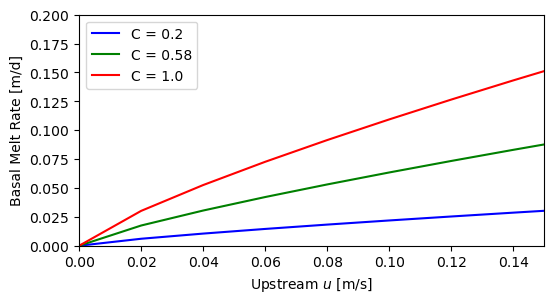

In [7]:
uo = np.arange(0,0.18,0.02)

fig, ax = plt.subplots(1, 1, figsize=(6,3))
cols = ['b', 'g', 'r']

for i, C in enumerate([0.2,0.58,1.0]):
    Mb = C * ((To-Ti)*(uo**0.8))/L**0.2
    ax.plot(uo, Mb, c=cols[i], label=f'C = {C}')
    ax.set_xlim([0,0.15])
    ax.set_ylim([0,0.2])
ax.set_xlabel(r'Upstream $u$ [m/s]')
ax.set_ylabel('Basal Melt Rate [m/d]')
ax.legend();

### Figure 3

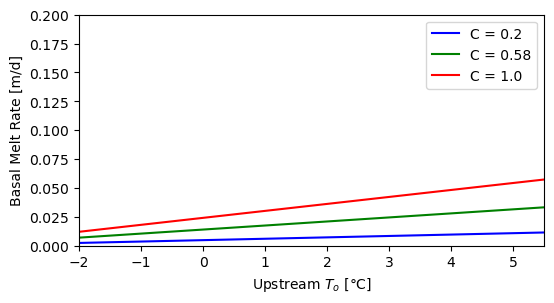

In [8]:
To = np.arange(-2,7,1)
uo = 0.02 # reset

fig, ax = plt.subplots(1, 1, figsize=(6,3))
cols = ['b', 'g', 'r']

for i, C in enumerate([0.2,0.58,1.0]):
    Mb = C * ((To-Ti)*(uo**0.8))/L**0.2
    ax.plot(To, Mb, c=cols[i], label=f'C = {C}')
    ax.set_xlim([-2,5.5])
    ax.set_ylim([0,0.2])
ax.set_xlabel(r'Upstream $T_o$ [°C]')
ax.set_ylabel('Basal Melt Rate [m/d]')
ax.legend();

### Figure 4

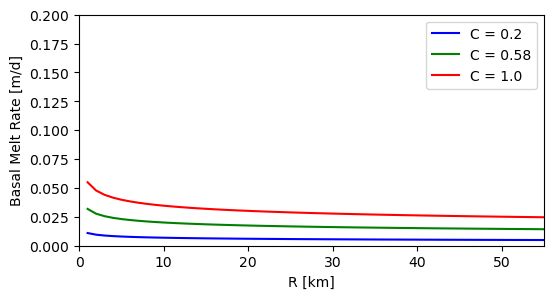

In [9]:
To = 1. # reset
L = np.arange(1000,70000,1000)

fig, ax = plt.subplots(1, 1, figsize=(6,3))
cols = ['b', 'g', 'r']

for i, C in enumerate([0.2,0.58,1.0]):
    Mb = C * ((To-Ti)*(uo**0.8))/L**0.2
    ax.plot(L/1000., Mb, c=cols[i], label=f'C = {C}')
    ax.set_xlim([0,55.])
    ax.set_ylim([0,0.2])
ax.set_xlabel('R [km]')
ax.set_ylabel('Basal Melt Rate [m/d]')
ax.legend();

### Figure 6

Note: inserted 0.015 m/s in bulk equation

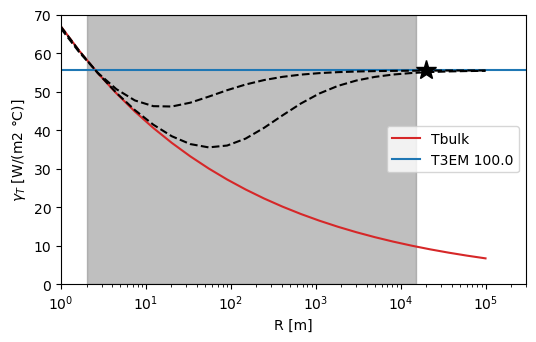

In [10]:
L = np.logspace(0,5,num=24) #20000.
Lo = 100.

cols = ['b', 'g', 'c', 'm', 'y']

fig, ax = plt.subplots(1, 1, figsize=(6,3.5))

# Bulk parameterisation
gamma_Tbulk = koT * 0.037 * Pr**(1/3.) * (0.015)**0.8 / (nu**0.8 * L**0.2)
ax.plot(L, gamma_Tbulk, c='tab:red', label='Tbulk')

# Adapted
gamma_T3EM = calc_gamma_T3EMv2(To, u, Lo)
ax.axhline(gamma_T3EM, c='tab:blue', label=f'T3EM {Lo}')

# Connected equations
g1 = ((1./(1. + 0.005 * L)) * gamma_Tbulk) + ((1. - (1./(1 + 0.005 * L))) * gamma_T3EM)
g2 = ((1./(1. + 0.05 * L)) * gamma_Tbulk) + ((1. - (1./(1 + 0.05 * L))) * gamma_T3EM)
ax.plot(L, g1, c='k', linestyle='--')
ax.plot(L, g2, c='k', linestyle='--')

# Layout
ax.axvspan(2, 15e3, alpha=0.5, color='grey')
ax.plot(20e3, gamma_T3EM, marker='*', c='k', markersize=15)

ax.set_xlim([1e0,3*1e5])
ax.set_ylim([0,70])
ax.set_xlabel('R [m]')
ax.set_ylabel(r'$\gamma_T$ [W/(m2 °C)]')
ax.set_xscale('log')
plt.legend(loc='center right');

### Figure 10

Test for several order of magnitudes of $L_o$.

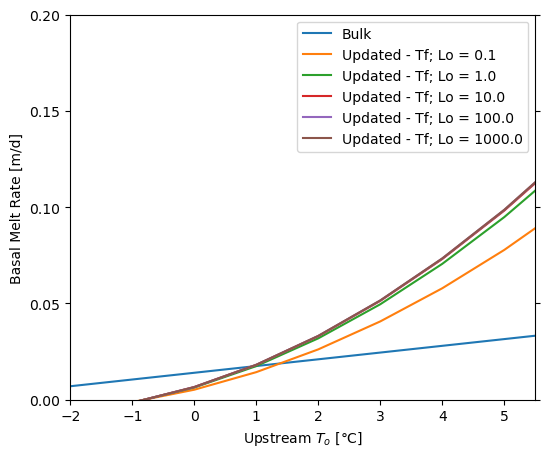

In [11]:
f = -1.4e-4
To = np.arange(-2,7,1)
Ti = -4.
uo = 0.02
L = 20000

fig, ax = plt.subplots(1, 1, figsize=(6,5))

Mb = 0.58 * ((To-Ti)*(uo**0.8))/L**0.2
ax.plot(To, Mb, label=f'Bulk')

for Lo in [0.1, 1., 10., 100., 1000.]:
    gamma_T3EM = calc_gamma_T3EM(To, uo, Lo)
# Mb2 = gamma_T3EM * (a*To + b - Tf) / (rho_i * Lf) * 86400.
# ax.plot(To, Mb2, linestyle='--', color='grey', label=f'Updated - Ti')
    Mb2 = gamma_T3EM * (a*To + b - (-5.73e-2*32 + 9.39e-2)) / (rho_i * Lf) * 86400.
    ax.plot(To, Mb2, label=f'Updated - Tf; Lo = {Lo}')
    # print(Lo, gamma_T3EM.mean(), Mb2.mean())

ax.set_xlim([-2,5.5])
ax.set_ylim([0,0.2])
ax.set_yticks([0.00, 0.05, 0.10, 0.15, 0.20])
ax.yaxis.set_ticks_position('both')
ax.set_xlabel(r'Upstream $T_o$ [°C]')
ax.set_ylabel('Basal Melt Rate [m/d]')
ax.legend();

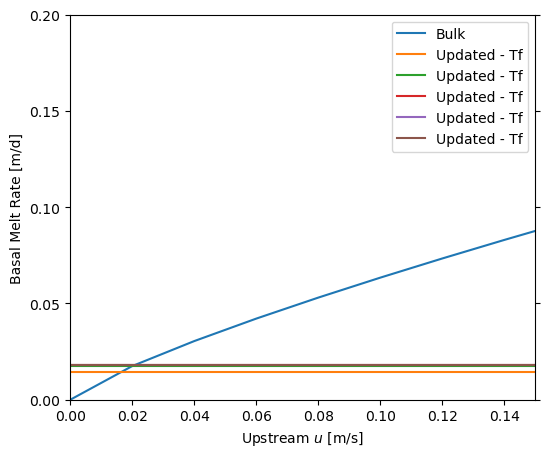

In [12]:
f = -1.4e-4
To = 1.
Ti = -4.
uo = np.arange(0,0.18,0.02)
L = 20000

fig, ax = plt.subplots(1, 1, figsize=(6,5))

Mb = 0.58 * ((To-Ti)*(uo**0.8))/L**0.2
ax.plot(uo, Mb, label=f'Bulk')

uo[0] = 0.00001
gamma_T3EM = np.zeros_like(uo)
Mb2 = np.zeros_like(uo)

for Lo in [0.1, 1., 10., 100., 1000.]:
    for i, u in enumerate(uo):
        gamma_T3EM[i] = calc_gamma_T3EM(To, 0.02, Lo)
        Mb2[i] = gamma_T3EM[i] * (a*To + b - (-5.73e-2*32 + 9.39e-2)) / (rho_i * Lf) * 86400.
    ax.plot(uo, Mb2, label=f'Updated - Tf')

ax.set_xlim([0,0.15])
ax.set_ylim([0,0.2])
ax.set_yticks([0.00, 0.05, 0.10, 0.15, 0.20])
ax.yaxis.set_ticks_position('both')
ax.set_xlabel(r'Upstream $u$ [m/s]')
ax.set_ylabel('Basal Melt Rate [m/d]')
ax.legend();

These agree well with the result of the paper for $L_o = 100$ m.

This value is also on the same order as hose found by Fer and Sundfjord (2007).

Note that using $T_f \approx \alpha S_o + \beta$ with $\alpha=-5.73e-2$ and $\beta=9.39e-2$ for $S_o=32$ is key here! This gives $T_f \approx -1.74$ compared to $T_i = -4$.

Show the variability in freezing temperature with salinity:

In [11]:
Ss = np.arange(32,35.1,0.2)
Tf_sal = np.zeros_like(Ss)
for i,S in enumerate(Ss):
    Tf_sal[i] = -5.73e-2*S + 9.39e-2
    print(f'For {S:2.1f} psu the freezing temperature Tf is {Tf_sal[i]:2.3f}')

For 32.0 psu the freezing temperature Tf is -1.740
For 32.2 psu the freezing temperature Tf is -1.751
For 32.4 psu the freezing temperature Tf is -1.763
For 32.6 psu the freezing temperature Tf is -1.774
For 32.8 psu the freezing temperature Tf is -1.786
For 33.0 psu the freezing temperature Tf is -1.797
For 33.2 psu the freezing temperature Tf is -1.808
For 33.4 psu the freezing temperature Tf is -1.820
For 33.6 psu the freezing temperature Tf is -1.831
For 33.8 psu the freezing temperature Tf is -1.843
For 34.0 psu the freezing temperature Tf is -1.854
For 34.2 psu the freezing temperature Tf is -1.866
For 34.4 psu the freezing temperature Tf is -1.877
For 34.6 psu the freezing temperature Tf is -1.889
For 34.8 psu the freezing temperature Tf is -1.900
For 35.0 psu the freezing temperature Tf is -1.912


In [12]:
Tf_sal.mean()

-1.825650000000001

# References

- Fer, I., & Sundfjord, A. (2007). Observations of upper ocean boundary layer dynamics in the
marginal ice zone. Journal of Geophysical Research, 112, C04012. https://doi.org/10.1029/2005JC003428
- FitzMaurice, A., & Stern, A. (2018). Parameterizing the basal melt of tabular icebergs. Ocean Mod-
elling, 130, 66–78. https://doi.org/10.1016/j.ocemod.2018.08.005
- Holland, D. M., & Jenkins, A. (1999). Modeling Thermodynamic Ice–Ocean Interactions at the
Base of an Ice Shelf. Journal of Physical Oceanography, 29(8), 1787–1800. https://doi.org/https://doi.org/10.1175/1520-0485(1999)029%3C1787:MTIOIA%3E2.0.CO;2